# Assignment 5 - Reinforcement Learning

## *Yifan Li*
Netid:  *yl506*

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [159]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [10]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
s0 = game.deal()
print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
s1 = game.step(1)
print(s1)

# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

(12, 10, False)
((22, 10, False), -1, True)


**ANSWER**

In [3]:
import numpy as np

total_reward = 0
win = 0
draw = 0

# Initialize the class:
game = Blackjack()


for i in range (1,51):
    # Deal the cards:    
    s0 = game.deal()
    print("\n\nGAME NO.{} :" .format(i))
    print(s0)
    
    while True:
        # Take an action: Hit = 1 or stay = 0.
        choice = input("Hit or stay? ")
        if choice == '1':
            s1 = game.step(1)
            print(s1)
        else:
            s1 = game.step(0)
            print(s1)
        if s1[2] == True:
            total_reward += s1[1]
            if s1[1] == 1:
                win += 1
                print("Nailed it")
            elif s1[1] == 0:
                draw += 1
                print("DRAW")
            else:
                print("Got rekt")    
            break

print("-=-=-=-=-=-=")            
print("GAME RECORD:")
print("W-D-L: {}-{}-{}".format(win, draw, 50-win))
print("Overall Average Reward: ", float(total_reward/50))



GAME NO.1 :
(11, 6, False)
Hit or stay? 1
((14, 6, False), 0, False)
Hit or stay? 1
((19, 6, False), 0, False)
Hit or stay? 0
((19, 6, False), 1.0, True)
Nailed it


GAME NO.2 :
(19, 7, False)
Hit or stay? 0
((19, 7, False), 1.0, True)
Nailed it


GAME NO.3 :
(20, 6, False)
Hit or stay? 0
((20, 6, False), -1.0, True)
Got rekt


GAME NO.4 :
(11, 9, False)
Hit or stay? 1
((19, 9, False), 0, False)
Hit or stay? 0
((19, 9, False), 0.0, True)
DRAW


GAME NO.5 :
(12, 10, False)
Hit or stay? 1
((21, 10, False), 0, False)
Hit or stay? 0
((21, 10, False), 1.0, True)
Nailed it


GAME NO.6 :
(19, 2, False)
Hit or stay? 0
((19, 2, False), 1.0, True)
Nailed it


GAME NO.7 :
(9, 10, False)
Hit or stay? 1
((17, 10, False), 0, False)
Hit or stay? 0
((17, 10, False), -1.0, True)
Got rekt


GAME NO.8 :
(20, 7, True)
Hit or stay? 0
((20, 7, True), 1.0, True)
Nailed it


GAME NO.9 :
(16, 1, False)
Hit or stay? 1
((26, 1, False), -1, True)
Got rekt


GAME NO.10 :
(21, 2, True)
Hit or stay? 0
((21, 2, Tru

From the above test results, total games won: $21$, games drew: $5$, games lost: $29$. And the resulting average reward is $-0.06$.

## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Repeat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

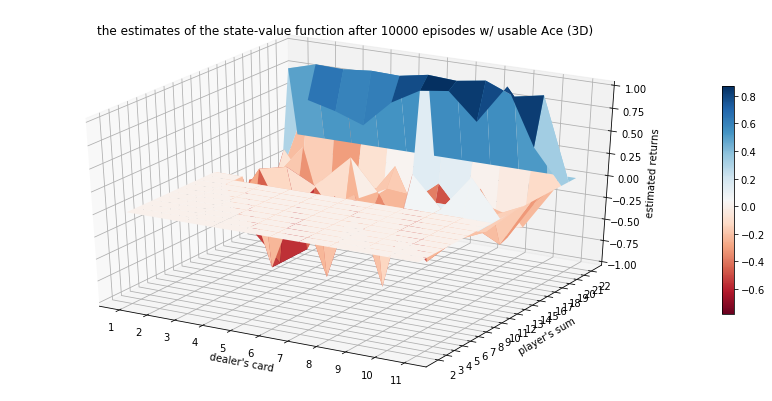

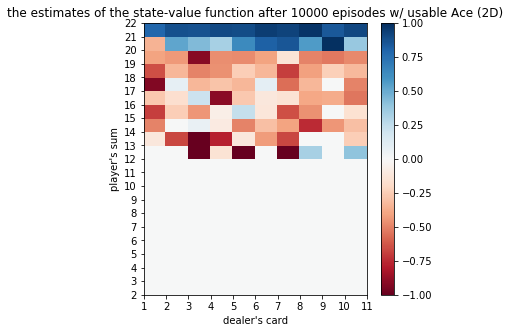

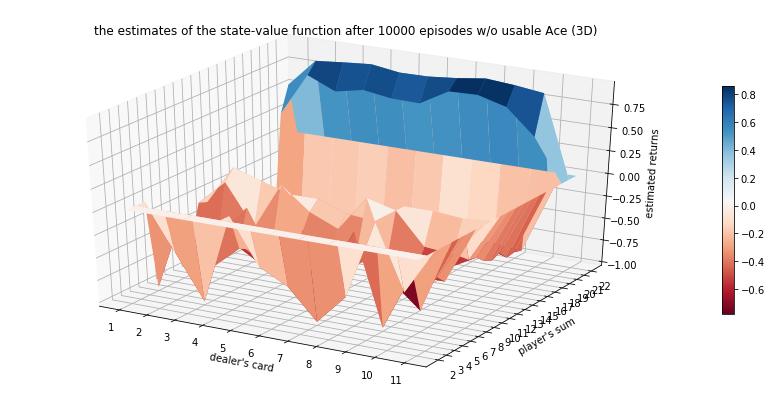

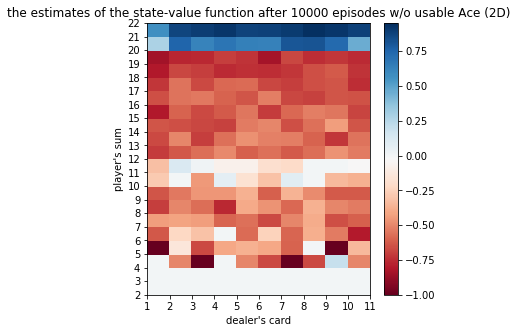

In [160]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

# Select a policy function to evaluate
def policy_function(state):
    if state[0] < 20:
        return 1 #hit
    else:
        return 0 #stay

# policy evaluation
def policy_evaluation(game, policy_fxn, episodes):
    totalReward = 0 # total reward for all episodes
    episodeNum = 0 # total number of episodes
    avgReward = [] # average rewards per episode
    
    stateReturns = defaultdict(float) # returns of each state (associative array)
    stateVisitedTimes = defaultdict(float) # number of time the state was visited
    avgReturns = defaultdict(float) # average returns of each state

    
    for i in range(1, episodes+1):
        state = game.deal()
        # Generate an episode (takes actions until a terminal state)
        thisEpisode = [] # detailed (state,reward) of one episode
        while True:
            action = policy_fxn(state)
            s1 = game.step(action)
            nextState = s1[0]
            reward = s1[1]
            gameover = s1[2]
            thisEpisode.append((state, reward)) # further used in map/dict
            if gameover == True:
                totalReward += reward
                break
            else:
                state = nextState
                
                
        episodeNum += 1 
        avgReward.append(totalReward / float(episodeNum)) # average reward per episode
        
        for j in range(len(thisEpisode)): # how many states
            # Save the returns following the first occurrence of each state
            returns = 0
            curr_state, curr_reward = thisEpisode[j]
            for k in range(j, len(thisEpisode)):
                returns += thisEpisode[k][1] # sum all rewards from beginning to the terminal
            stateReturns[curr_state] += returns # keep track of Gt and update when needed
            stateVisitedTimes[curr_state] += 1 # used to average
            avgReturns[curr_state] = stateReturns[curr_state] / stateVisitedTimes[curr_state]
            
    return avgReturns, avgReward

# perform evaluation and plot 
game = Blackjack()
avgReturns_10000, avgReward_10000 = policy_evaluation(game, policy_function, 10000)
avgReturns_500000, avgReward_500000 = policy_evaluation(game, policy_function, 500000)
x = np.arange(1, 12) # dealer's card (1 - 10)
y = np.arange(2, 23) # sum of player's cards (2 - 21)
X, Y = np.meshgrid(x, y)

Z_10000_aceUsable = np.array([avgReturns_10000[(y, x, True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z_10000_aceUnusable = np.array([avgReturns_10000[(y, x, False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z_500000_aceUsable = np.array([avgReturns_500000[(y, x, True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z_500000_aceUnusable = np.array([avgReturns_500000[(y, x, False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])

# ((a).1)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_10000_aceUsable.reshape(X.shape), cmap='RdBu')
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
ax.set_xlabel("dealer's card")
ax.set_ylabel("player's sum")
ax.set_zlabel("estimated returns")
plt.title("the estimates of the state-value function after 10000 episodes w/ usable Ace (3D)")
fig.colorbar(surf, shrink=0.6)

plt.figure(figsize=(5,5))
plt.pcolor(X, Y, Z_10000_aceUsable.reshape(X.shape), cmap='RdBu')
plt.colorbar()
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("the estimates of the state-value function after 10000 episodes w/ usable Ace (2D)")


# ((a).2)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_10000_aceUnusable.reshape(X.shape), cmap='RdBu')
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
ax.set_xlabel("dealer's card")
ax.set_ylabel("player's sum")
ax.set_zlabel("estimated returns")
plt.title("the estimates of the state-value function after 10000 episodes w/o usable Ace (3D)")
fig.colorbar(surf, shrink=0.6)

plt.figure(figsize=(5,5))
plt.pcolor(X, Y, Z_10000_aceUnusable.reshape(X.shape), cmap='RdBu')
plt.colorbar()
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("the estimates of the state-value function after 10000 episodes w/o usable Ace (2D)")

plt.show()

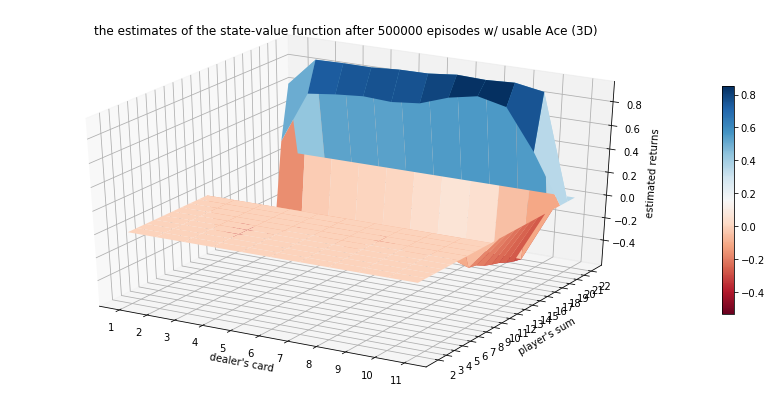

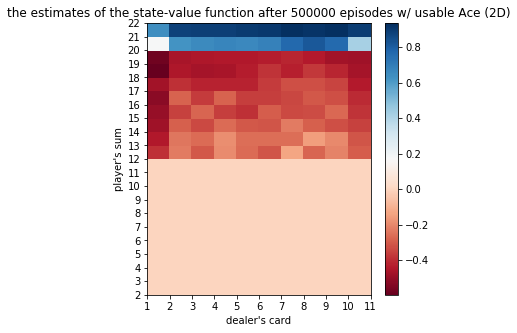

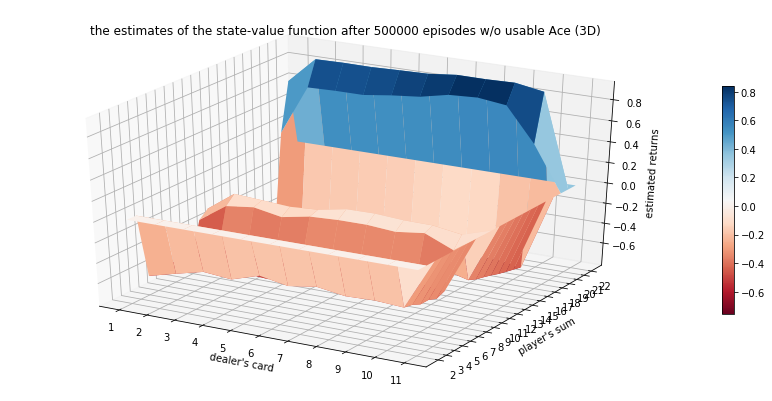

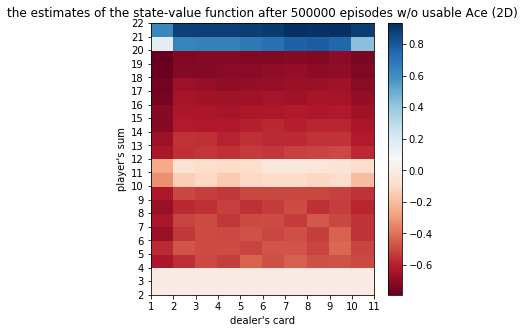

In [161]:
# ((a).3)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_500000_aceUsable.reshape(X.shape), cmap='RdBu')
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
ax.set_xlabel("dealer's card")
ax.set_ylabel("player's sum")
ax.set_zlabel("estimated returns")
plt.title("the estimates of the state-value function after 500000 episodes w/ usable Ace (3D)")
fig.colorbar(surf, shrink=0.6)

plt.figure(figsize=(5,5))
plt.pcolor(X, Y, Z_500000_aceUsable.reshape(X.shape), cmap='RdBu')
plt.colorbar()
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("the estimates of the state-value function after 500000 episodes w/ usable Ace (2D)")


# ((a).4)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_500000_aceUnusable.reshape(X.shape), cmap='RdBu')
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
ax.set_xlabel("dealer's card")
ax.set_ylabel("player's sum")
ax.set_zlabel("estimated returns")
plt.title("the estimates of the state-value function after 500000 episodes w/o usable Ace (3D)")
fig.colorbar(surf, shrink=0.6)

plt.figure(figsize=(5,5))
plt.pcolor(X, Y, Z_500000_aceUnusable.reshape(X.shape), cmap='RdBu')
plt.colorbar()
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("the estimates of the state-value function after 500000 episodes w/o usable Ace (2D)")

plt.show()

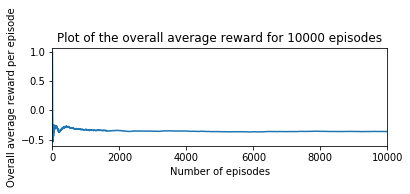

The overall average reward per episode for 10000 episodes is -0.3519871722232963


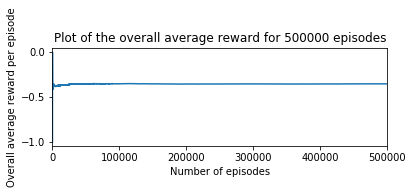

The overall average reward per episode for 500000 episodes is -0.35523225135055403


In [110]:
# (b)
plt.figure()
plt.subplot(2,1,1)
plt.title("Plot of the overall average reward for 10000 episodes")
plt.ylabel("Overall average reward per episode")
plt.xlabel("Number of episodes")
plt.xlim((0, 10000))
plt.plot(range(0,len(avgReward_10000)), [avgReward_10000[i] for i in range(0,len(avgReward_10000))])

totalReward_10000 = 0
for i in range(0,len(avgReward_10000)):
    totalReward_10000 += avgReward_10000[i]
plt.show()
print("The overall average reward per episode for 10000 episodes is", totalReward_10000/len(avgReward_10000))

plt.subplot(2,1,2)
plt.title("Plot of the overall average reward for 500000 episodes")
plt.ylabel("Overall average reward per episode")
plt.xlabel("Number of episodes")
plt.xlim((0, 500000))
plt.plot(range(0,len(avgReward_500000)), [avgReward_500000[i] for i in range(0,len(avgReward_500000))])

totalReward_500000 = 0
for i in range(0,len(avgReward_500000)):
    totalReward_500000 += avgReward_500000[i]
plt.show()
print("The overall average reward per episode for 500000 episodes is", totalReward_500000/len(avgReward_500000))


## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

**ANSWER**

In [153]:
import numpy as np
from collections import defaultdict
from random import *

# new policy function
def policy_function(policySet, state, epsilon):
    a_star = policySet[state]
    if (a_star == 1):
        a_other = 0
    else:
        a_other = 1
        
    prob_a_star = random()
    if prob_a_star >= epsilon:
        return a_star # exploit
    else:
        return a_other # explore

def policy_iteration(game, policy_fxn, iterations):
    totalReward = 0 # total reward for all episodes
    episodeNum = 0 # total number of episodes
    avgReward = [] # average rewards per episode
    
    numOfTimesSelected = defaultdict(int) # (state, action)
    policySet = defaultdict(float)
    stateReturns = defaultdict(float) # returns of each state
    avgReturns = defaultdict(float) # average returns of each state
    
    N_0 = 100
    
    for i in range(1, iterations+1):
        state = game.deal()
        # Generate an episode (takes actions until a terminal state)
        thisEpisode = [] # detailed (state,reward,action) of one episode
        while True:
            # number of times selected for this state
            N_st = numOfTimesSelected[(state,0)] + numOfTimesSelected[(state,1)]
            epsilon_new = N_0 / (N_0+N_st)
            action = policy_fxn(policySet, state, epsilon_new)
            s1 = game.step(action)
            nextState = s1[0]
            reward = s1[1]
            gameover = s1[2]
            thisEpisode.append((state, reward, action)) # further used in map/dict
            if gameover == True:
                totalReward += reward
                break
            else:
                state = nextState
            
        episodeNum += 1
        avgReward.append(totalReward / float(episodeNum)) # average reward per episode
        
        for j in range(len(thisEpisode)): # how many states
            # Save the returns following the first occurrence of each state
            returns = 0
            curr_state, curr_reward, curr_action = thisEpisode[j]
            for k in range(j, len(thisEpisode)):
                returns += thisEpisode[k][1] # sum all rewards from beginning to the terminal
            stateReturns[(curr_state, curr_action)] += returns # keep track of Gt and update when needed
            numOfTimesSelected[(curr_state, curr_action)] += 1 # used to average
            avgReturns[(curr_state, curr_action)] = stateReturns[(curr_state, curr_action)]/numOfTimesSelected[(curr_state, curr_action)]
        
        # policy update
        for m in range(len(thisEpisode)):
            curr_state = thisEpisode[m][0]
            if avgReturns[(curr_state,1)] > avgReturns[(curr_state,0)]:
                policySet[curr_state] = 1
            else:
                policySet[curr_state] = 0
    
    return avgReturns, avgReward, policySet
    

In [154]:
game = Blackjack()
avgReturns, avgReward, PolicySet = policy_iteration(game, policy_function, 10000000)

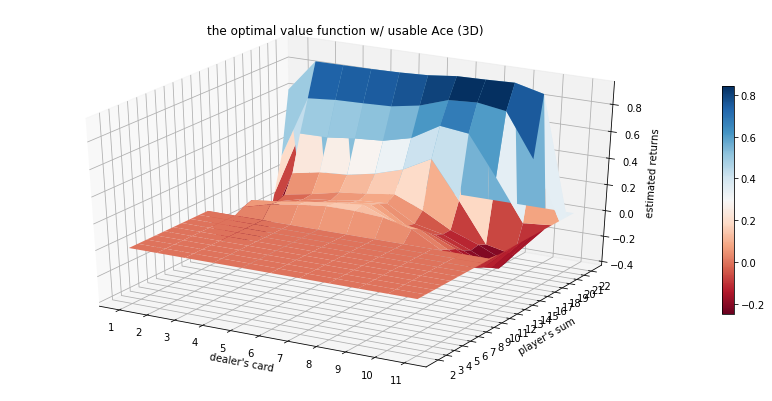

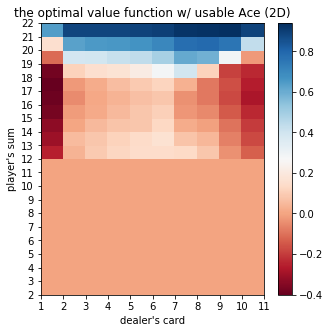

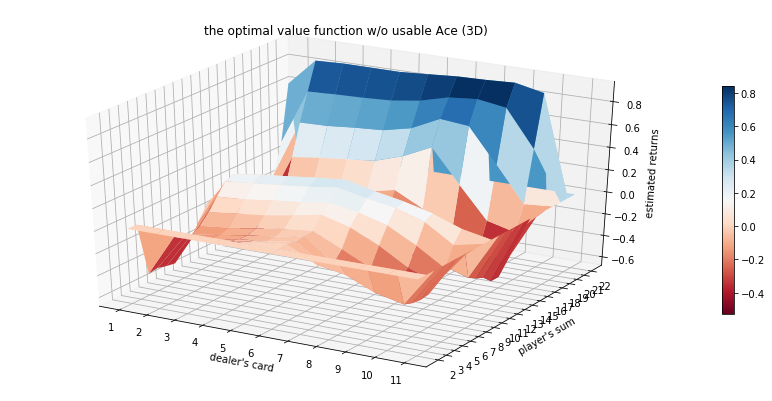

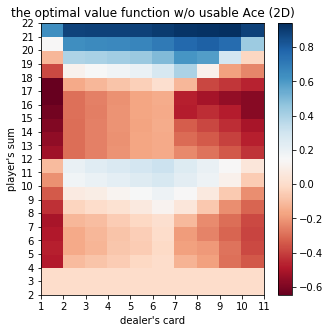

In [155]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(1, 12) # dealer's card (1 - 10)
y = np.arange(2, 23) # sum of player's cards (2 - 21)
X, Y = np.meshgrid(x, y)
V_aceUsable = np.maximum( np.array([avgReturns[((y,x,True),0)] for (x,y) in zip(np.ravel(X), np.ravel(Y))]), 
                        np.array([avgReturns[((y,x,True),1)] for (x,y) in zip(np.ravel(X), np.ravel(Y))]) )
V_aceUnusable = np.maximum( np.array([avgReturns[((y,x,False),0)] for (x,y) in zip(np.ravel(X), np.ravel(Y))]), 
                        np.array([avgReturns[((y,x,False),1)] for (x,y) in zip(np.ravel(X), np.ravel(Y))]) )

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, V_aceUsable.reshape(X.shape), cmap='RdBu')
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
ax.set_xlabel("dealer's card")
ax.set_ylabel("player's sum")
ax.set_zlabel("estimated returns")
plt.title("the optimal value function w/ usable Ace (3D)")
fig.colorbar(surf, shrink=0.6)

plt.figure(figsize=(5,5))
plt.pcolor(X, Y, V_aceUsable.reshape(X.shape), cmap='RdBu')
plt.colorbar()
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("the optimal value function w/ usable Ace (2D)")

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, V_aceUnusable.reshape(X.shape), cmap='RdBu')
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
ax.set_xlabel("dealer's card")
ax.set_ylabel("player's sum")
ax.set_zlabel("estimated returns")
plt.title("the optimal value function w/o usable Ace (3D)")
fig.colorbar(surf, shrink=0.6)

plt.figure(figsize=(5,5))
plt.pcolor(X, Y, V_aceUnusable.reshape(X.shape), cmap='RdBu')
plt.colorbar()
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("the optimal value function w/o usable Ace (2D)")

plt.show()

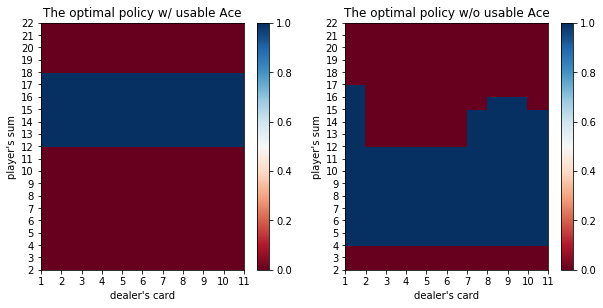

In [157]:
PI_aceUsable = np.array([policy_function(PolicySet, (y,x,True), 0) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
PI_aceUnusable = np.array([policy_function(PolicySet, (y,x,False), 0) for (x,y) in zip(np.ravel(X), np.ravel(Y))])

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.pcolor(X, Y, PI_aceUsable.reshape(X.shape), cmap='RdBu')
plt.colorbar()
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("The optimal policy w/ usable Ace")


plt.subplot(2,2,2)
plt.pcolor(X, Y, PI_aceUnusable.reshape(X.shape), cmap='RdBu')
plt.colorbar()
plt.yticks(np.arange(2, 23))
plt.xticks(np.arange(1, 12))
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("The optimal policy w/o usable Ace")
plt.show()

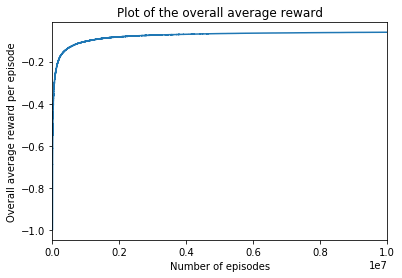

The overall average reward per episode is -0.07847143757191184


In [158]:
# (b)
plt.figure()
plt.title("Plot of the overall average reward")
plt.ylabel("Overall average reward per episode")
plt.xlabel("Number of episodes")
plt.xlim((0, 10000000))
plt.plot(range(0,len(avgReward)), [avgReward[i] for i in range(0,len(avgReward))])
plt.show()

totalReward = 0
for i in range(0,len(avgReward)):
    totalReward += avgReward[i]
print("The overall average reward per episode is", totalReward/len(avgReward))

## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

**(a)**

So it turns out that the optimal control policy performs much better than the naive policy since the overall average reward increases from -0.35 to -0.07. And although my human control policy has an even slight higher average reward than the optimal control policy, it does not amount to being the best policy since there are only 50 trials and I might get lucky most of the time. Also, the above results of optimal control policy were got after 10 million episodes, and the algorithm may still not fully converge yet. So in the long run, the optimal control policy should perform best. 

**(b)**
If the full Markov Decision Process is known, all the related components such as transition probabilities, state space, rewards, and actions are known. There is always a deterministic optimal policy for any MDP. So, in this case, the process of computing and updating optimal policy will be much more accurate and thus, we should be able to create a better policy.